In [4]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
%matplotlib inline

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [5]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [6]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

## Ежемесячные продажи автомобилей за 1960 год

In [79]:
series = pd.read_csv("monthly-car-sales-in-quebec-1960.csv")

In [80]:
notstac=series.copy()

In [60]:
stac = series

In [38]:
series.head()

,Month,Count
0,1960-01,6550
1,1960-02,8728
2,1960-03,12026
3,1960-04,14395
4,1960-05,14587


In [39]:
series=series['Count']

In [40]:
# Запустим тест Дики-Фуллера и построим графики Автокорелляции

Results of Dickey-Fuller Test:
Test Statistic                 -1.223813
p-value                         0.663269
#Lags Used                     12.000000
Number of Observations Used    95.000000
Critical Value (1%)            -3.501137
Critical Value (5%)            -2.892480
Critical Value (10%)           -2.583275
dtype: float64


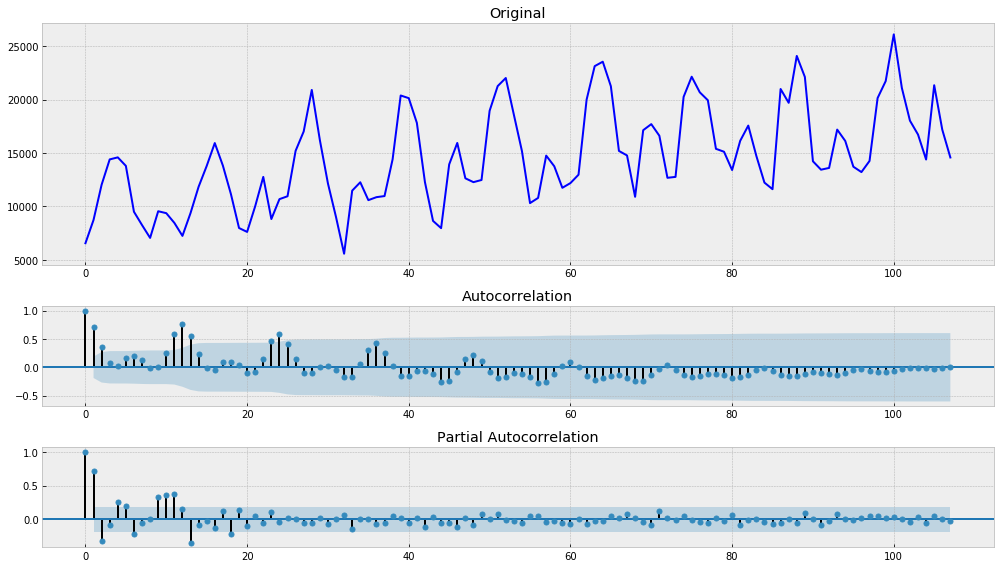

In [41]:
tsplot(series)

### P_value имеет высокое значение, значит ряд не можем назвать стационарным. 
### На графике автокорреляций видна сезонность, и обнаружено большое количество выбрасов в начале. Что не было очевидно на первоначально графике. 

### РАзная дисперсия от периода к периоду. Попробуем убрать изменчивость с помощью преобразования бокса-кокса.



In [42]:
box = boxcox(series, 0)

Results of Dickey-Fuller Test:
Test Statistic                 -1.452425
p-value                         0.556901
#Lags Used                     13.000000
Number of Observations Used    94.000000
Critical Value (1%)            -3.501912
Critical Value (5%)            -2.892815
Critical Value (10%)           -2.583454
dtype: float64


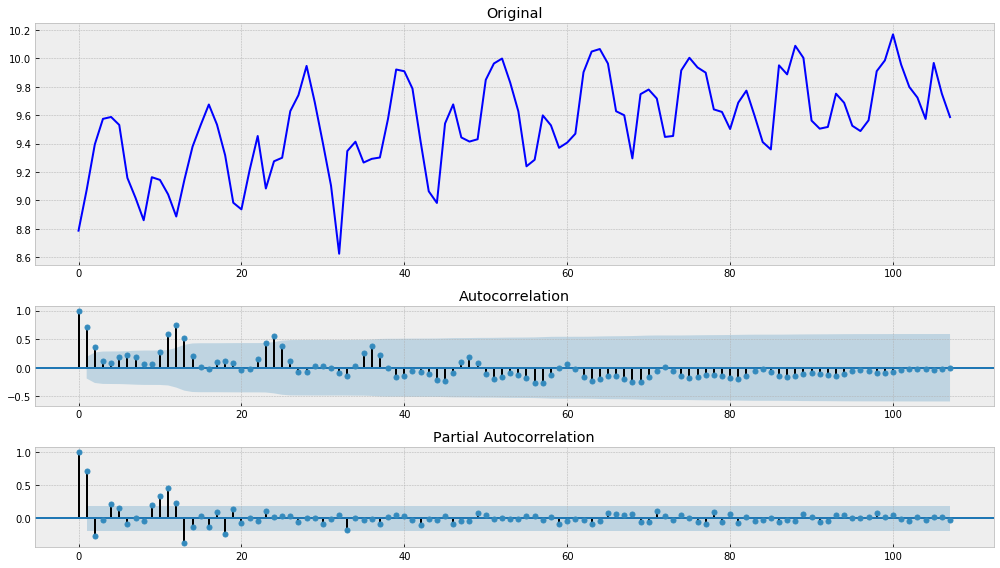

In [43]:
tsplot(box)

In [44]:
box = box[12:] - box[:-12]

Results of Dickey-Fuller Test:
Test Statistic                 -4.529131
p-value                         0.000174
#Lags Used                      1.000000
Number of Observations Used    94.000000
Critical Value (1%)            -3.501912
Critical Value (5%)            -2.892815
Critical Value (10%)           -2.583454
dtype: float64


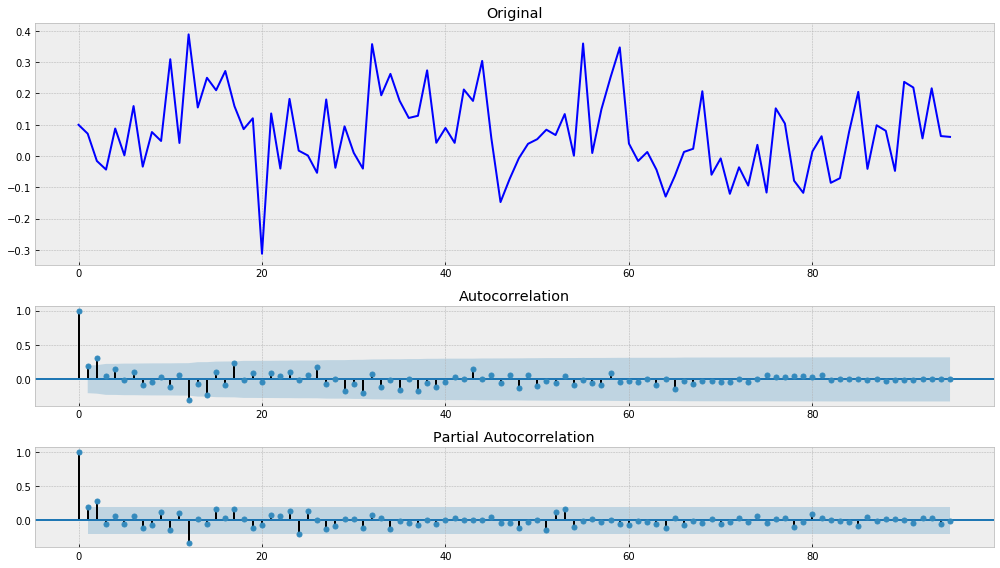

In [45]:
tsplot(box)

#### После преобразования бокса кокса и дифференицирования получили неоднозначно хороший результат. На основном графике 
продолжаем видеть большой размах дисперсии, но график автокорреляции и значение Значение P value 
отвергают гипотезу о нестационарности ряда.

In [51]:
box.shape

(96,)

In [53]:
stac['Count'][:96]= box

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [62]:
stac=stac.iloc[:96]

### stac - стационарный ряд
### notstac - нестационарный ряд

In [27]:
def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()

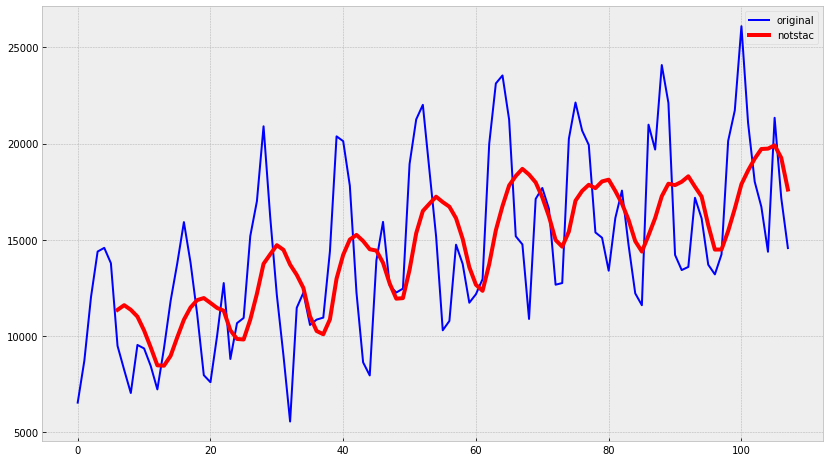

In [33]:
ser = moving_average(notstac["Count"], 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(notstac["Count"], color='blue',label='original')
    plt.plot(ser, color='red', linewidth='4', label='notstac')
    plt.legend()

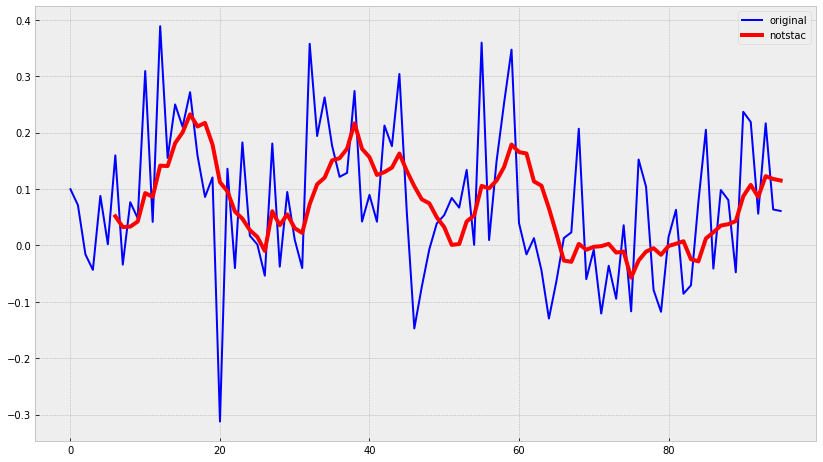

In [65]:
ser = moving_average(stac, 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(stac, color='blue',label='original')
    plt.plot(ser, color='red', linewidth='4', label='notstac')
    plt.legend()

##  На основании данных графиков, при нестационарном ряде модель больше следует основному графику. При стационарном ряде видно, что модель практически не идет за основным графиком

In [66]:
def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

In [100]:
def plot_stat(alpha, beta):
    dema = double_ema(stac, alpha, beta)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(stac, color='blue',label='original')
        plt.plot(dema, color='red', linewidth='4', label='DEMA')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.legend()

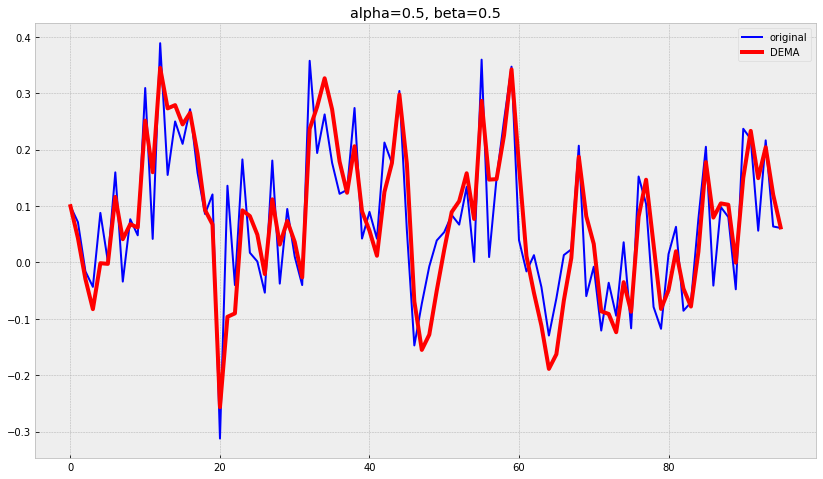

In [101]:
plot_stat(0.5, 0.5)

In [98]:
def plot_notstat(alpha, beta):
    dema = double_ema(notstac['Count'], alpha, beta)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(notstac['Count'], color='blue',label='original')
        plt.plot(dema, color='red', linewidth='4', label='DEMA')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.legend()

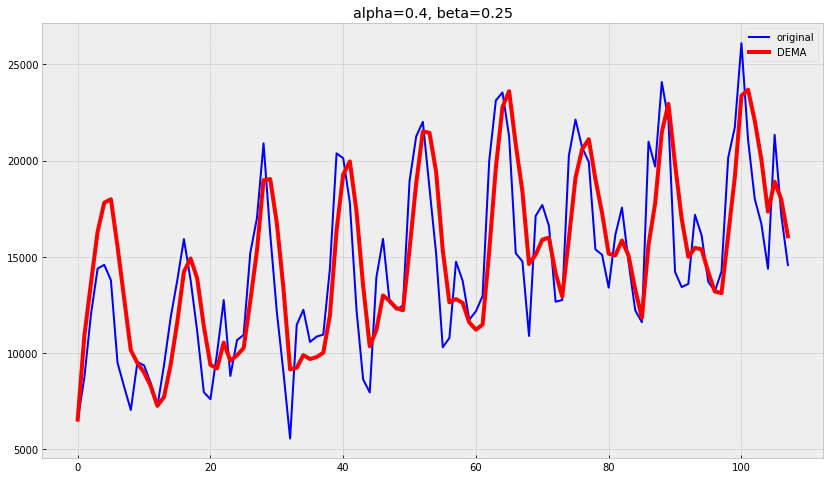

In [99]:
plot_notstat(0.4, 0.25)

## На модели двойного экспоненциального сглаживания получаются примерно одинаковые результаты как на стационарном, так и нестационарном ряде.

In [118]:
def initial_trend(series, season_len):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

In [119]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [133]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [157]:
def plot_tema(alpha, beta, gamma, ser, ser_to_plot, n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

##  Нестационарный ряд

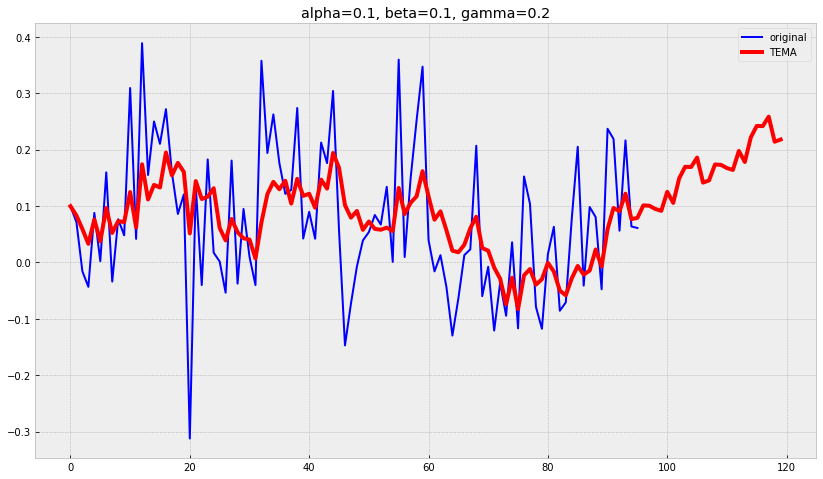

In [158]:
plot_tema(0.1, 0.1, 0.2, stac, stac)

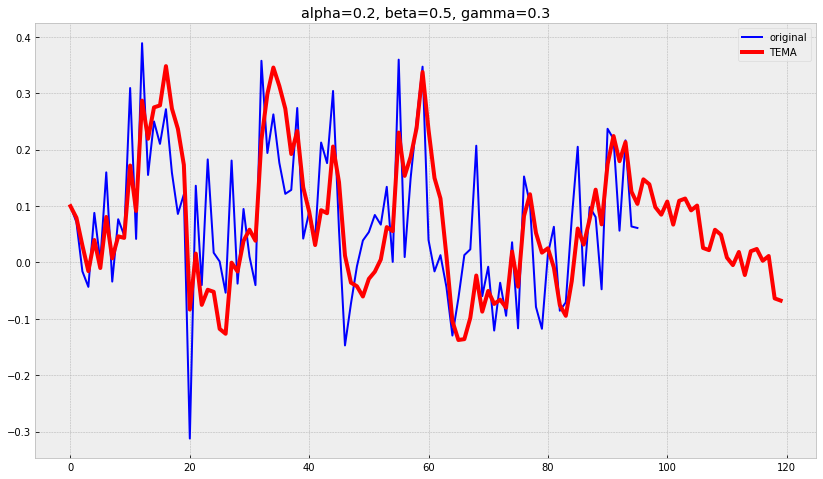

In [159]:
plot_tema(0.2, 0.5, 0.3, stac, stac)

##   Стационарный ряд

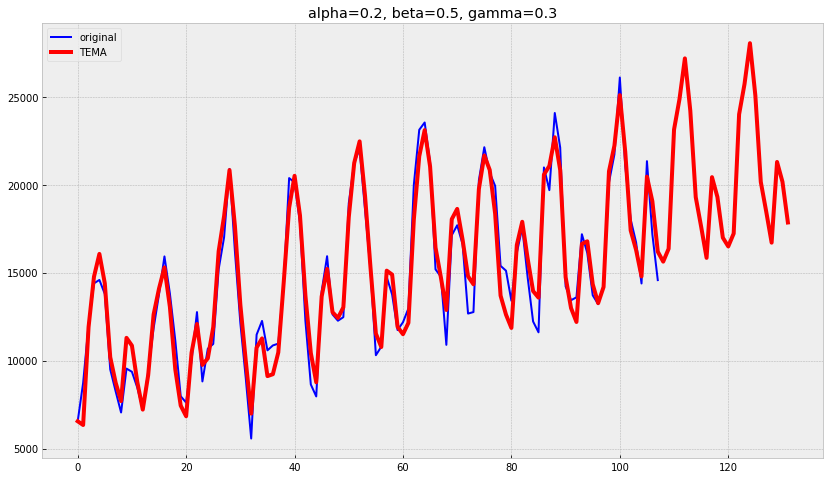

In [161]:
plot_tema(0.2, 0.5, 0.3, notstac['Count'], notstac['Count'])

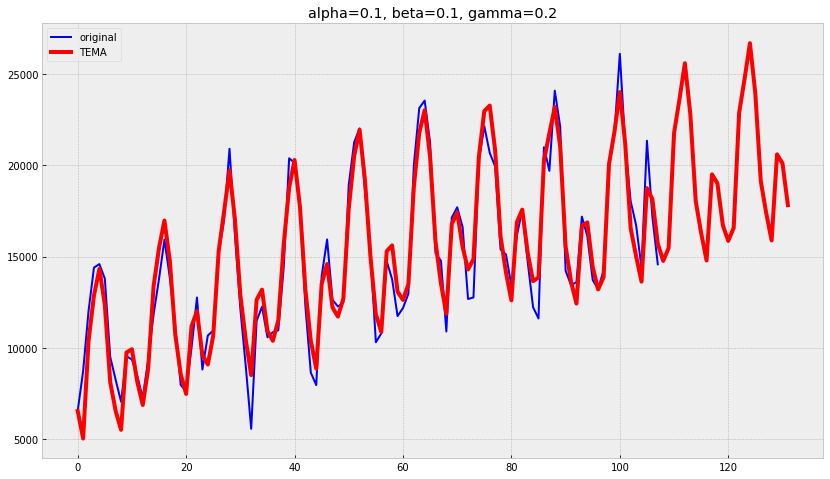

In [162]:
plot_tema(0.1, 0.1, 0.2, notstac['Count'], notstac['Count'])

#  Выводы: Обыные методы скользящих средних одинаково себя показывают как на стационарном, так и нестационарном ряде. Но для прогноза они не годятся. 


# Если взять более серьезную модель тройного экспоненциального сглаживания, то очевидно, модель хорошо работает только на стационарном ряде и дает хорошие предсказания в будущее. В обычном же нестационарном ряде ведет себя совершенно не точно, и прознозы сильно зависят от параметров. 